In [1]:
%matplotlib inline
%load_ext autoreload

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join, exists
from os import mkdir
from glob import glob
import sys

sys.path.append(os.path.abspath('..'))

from scripts.train_simclr import *
from scripts.util import _parse_function, _sample_from_tfrecord

2024-07-19 22:41:04.211758: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 22:41:04.891994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Set Up Dataset

In [2]:
ds = build_dataset(
    dataset_dir=FLAGS.dataset_dir,
    patch_size=FLAGS.input_s,
    shuffle=True,
    n_parallel=-1,
    max_ex=FLAGS.max_ex,
    return_len=False
)
hp = {}
aug_params = {
    "blur_radius": hp.get("blur_radius", FLAGS.blur_radius),
    "blur_p": hp.get("blur_p", FLAGS.blur_p),
    "crop_frac": hp.get("crop_frac", FLAGS.crop_frac),
    "rotate_limit": hp.get("rotate_limit", FLAGS.rotate_limit),
}

base_path = '/home/ubuntu/notebooks/cpc_hist/'
ds = prepare_dataset(
    ds,
    base_path,
    tile_size=FLAGS.input_s,
    batch_size=FLAGS.bs,
    aug_params=aug_params,
    num_parallel_calls=-1,
    preFetch=-1,
    train_size=-1,
)

2024-07-19 22:41:06,025 Using Dataset located at /home/ubuntu/notebooks/cpc_hist/resources/tfrecords
2024-07-19 22:41:06.091872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-19 22:41:06.113888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-19 22:41:06.114936: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning N

## Show Examples

2024-07-19 22:41:07.274902: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4710]
	 [[{{node Placeholder/_0}}]]
2024-07-19 22:41:07.275402: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4710]
	 [[{{node Placeholder/_0}}]]
2024-07-19 22:41:26.338607: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201326592 exceeds 10% of free system memory.
2024-07-19 22:41:27.235829: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201326592 exceeds 10% of free system memory.
2024-07-19 22:41:29.916761: W te

(256, 256, 256, 3)


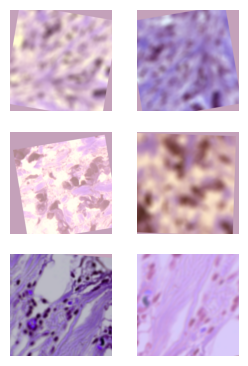

In [3]:
test_batch = next(iter(ds))
bs = test_batch.shape[0]
print(test_batch.shape)

N = 3
fig, axes = plt.subplots(N, 2, figsize=(3, 1.5 * N))
for i, ax in enumerate(axes[:, 0].flat):
    ax.imshow(test_batch[i].numpy())
    ax.axis('off')
for i, ax in enumerate(axes[:, 1].flat):
    ax.imshow(test_batch[i + bs // 2].numpy())
    ax.axis('off')

plt.show()

# Setting up Model

In [4]:
hp = {}
model = build_model(hp)
model.build((FLAGS.bs, FLAGS.input_s, FLAGS.input_s, 3))

In [5]:
model.summary()

Model: "SimCLR_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 projection_head (Projectio  multiple                  4467200   
 nHead)                                                          
                                                                 
Total params: 47125376 (179.77 MB)
Trainable params: 47015680 (179.35 MB)
Non-trainable params: 109696 (428.50 KB)
_________________________________________________________________


Model: "SimCLR_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 projection_head (Projectio  multiple                  4467200   
 nHead)                                                          
                                                                 
Total params: 47125376 (179.77 MB)
Trainable params: 47015680 (179.35 MB)
Non-trainable params: 109696 (428.50 KB)
_________________________________________________________________
